# **Übung 6: Wirbelleiterverfahren**

In [456]:
# Importieren von Python-Biblioteken
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ipywidgets import IntSlider, fixed, VBox, HBox, Label
import ipywidgets as widgets
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import time

# Erhöhen der Plot-Auflösung
plt.rcParams["figure.dpi"] = 140

### 6.1.1 Visualisierung Pfeilflügel

In [457]:
def pfeilfluegel(s, phi, c=1) -> np.array:
    """Generiert die Planform eines gepfeilten Rechteckflügels auf Basis der Spannweite und Pfeilung"""
    shift = s * np.tan(np.radians(phi))

    # Definition aller Eckpunkte
    points = np.array([
        [0, 0], [s, shift], [s, c + shift], [0, c], 
        [-s, c + shift], [-s, shift], [0, 0]])
    
    return points


def plot_pfeilfluegel(s, phi):
    """Plottet die Planform eines gepfeilten Rechteckflügels auf Basis der Spannweite und Pfeilung"""
    
    # Flügeleckpunkte generieren
    points = pfeilfluegel(s, phi)

    # Geometrie plotten
    plt.figure(figsize=(7, 3))
    plt.plot(points[:,0], points[:, 1], '-', color="black")
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Pfeilflügel')
    plt.gca().invert_yaxis()
    plt.axis('equal')
    plt.show()


def widget_pfeilfluegel():
    """Erzeugt ein widget, mit dem sich die Planform eines gepfeilten Rechteckflügels interaktiv visualisieren lässt"""

    slider_s = VBox([Label('Halbspannweite [m]'), IntSlider(value=3, min=1, max=20)])
    slider_phi = VBox([Label('Pfeilwinkel [deg]'), IntSlider(value=15, min=0, max=60)])

    # Interaktiver plot
    ui = VBox([slider_s, slider_phi])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_pfeilfluegel, {'s': slider_s.children[1], 'phi': slider_phi.children[1]})

    return HBox([out, ui])

In [458]:
display(widget_pfeilfluegel())

### 6.1.2 Geometrische Parameter und Randbedinungen

In [459]:
# Konstant
phi = np.radians(15)        # Pfeilungswinkel (in rad)
b = 15                      # Spannweite
s = b/2                     # Halbspannweite
c = 1                       # Flügeltiefe
AR = 12                     # Streckung
U_inf = 30                  # Anströmgeschwindigkeit (in m/s)
alpha = np.radians(5)       # Anstellwinkel (in rad)
rho = 1                     # Luftdichte (in kg/m^3)
k_Gamma = 0.25              # Skalierung der Wirbelposition
k_A = 0.75                  # Skalierung des Aufpunkts

### 6.1.3 Vernetzen des Tragflügels

In [460]:
def plot_diskretisierung_pfeil(N, M, s=3, c=1):
    """Plottet die Diskretisierung eines gepfeilten Rechteckflügels auf Basis der Anzahl der Elementarflügel"""

    points = pfeilfluegel(s, np.degrees(phi))
    
    # Diskretisierung der Halbspannweite
    y_values = np.linspace(-s, s, N+1)
    x_values = np.linspace(0, c, M+1)
    
    # Geometrie plotten
    plt.figure(figsize=(6, 3))
    plt.plot(points[:,0], points[:, 1], '-', color="black")

    # Panele plotten
    for i in range(N+1):
        shift = abs(y_values[i]) * np.tan(phi)
        plt.plot([y_values[i], y_values[i]], [shift, shift + c], 'g-', linewidth=0.5)

    for j in range(M+1):
        plt.plot([-s, 0, s], [x_values[j] + shift, x_values[j], x_values[j] + shift], 'g-', linewidth=0.5)
    
    plt.vlines(0, 0, 1, "black", "--")
    plt.xlabel('Spannweite [m]')
    plt.ylabel('Flügeltiefe [m]')
    plt.title('Diskretisierung Pfeilflügel')
    plt.axis('equal')
    plt.gca().invert_yaxis()
    plt.show()


def widget_diskretisierung_pfeil():
    """Erzeugt ein widget, mit dem sich die Diskretisierung eines gepfeilten Rechteckflügels interaktiv visualisieren lässt"""

    slider_N = VBox([Label('Anzahl horizontaler Panele'), IntSlider(value=20, min=1, max=100)])
    slider_M = VBox([Label('Anzahl vertikaler Panele'), IntSlider(value=5, min=1, max=60)])

    # Interaktiver plot
    ui = VBox([slider_N, slider_M])
    ui = VBox([ui], layout=widgets.Layout(justify_content='center'))
    out = widgets.interactive_output(plot_diskretisierung_pfeil, {'N': slider_N.children[1], 'M': slider_M.children[1]})
    return HBox([out, ui])

In [461]:
display(widget_diskretisierung_pfeil())

# 🟠

In [462]:
# Diese Parameter können verändert werden
N = 60                      # Anzahl horizontaler Panele
M = 20                       # Anzahl vertikaler Panele

# Berechne Paneldimensionen
Delta_y = b / N
Delta_x = c / M

### 6.1.4 Berechnung der Panelpunkte A, B und C

In [463]:
def compute_coords(s, phi, N, M):
    """
    Berechnet die Koordinaten der induzierenden Punkte A und B sowie der Aufpunkte C der Panele auf einem gepfeilten Rechteckflügel.
    Die Punkte A und B werden am linken und rechten Rand auf der 1/4 Linie jedes Panels berechnet.
    Die Aufunkte werden mittig auf der 3/4 Linie jedes Panels berechnet.
    """
    
    # Diskretisierung der Halbspannweite und Flügeltiefe
    y_values = np.linspace(-s, s, N+1)
    x_values = np.linspace(0, 1, M+1)
    
    # Berechnung der mittigen Punkte in Spannweiten- und Tiefenrichtung
    y_panel_centers = (y_values[:-1] + y_values[1:]) / 2

    # Arrays für die Koordinaten
    X_A = np.zeros((N, M))
    Y_A = np.zeros((N, M))
    X_B = np.zeros((N, M))
    Y_B = np.zeros((N, M))
    X_C = np.zeros((N, M))
    Y_C = np.zeros((N, M))
    
    for i in range(N):
        for j in range(M):
            # A
            # Shift wegen des Pfeilwinkels (Verschiebung der x-Koordinate entlang der y-Achse)
            shift = abs(y_values[i]) * np.tan(phi)
            X_A[i, j] = shift + x_values[j] + k_Gamma * c / M     # Punkt auf der 1/4 Linie
            Y_A[i, j] = y_values[i]                                 # am linken Rand des Panels

            # B
            shift = abs(abs(y_values[i+1])) * np.tan(phi)
            X_B[i, j] = shift + x_values[j] + k_Gamma * c / M     # Punkt auf der 1/4 Linie
            Y_B[i, j] = y_values[i+1]                               # am rechten Rand des Panels

            # C
            shift = abs(y_panel_centers[i]) * np.tan(phi)
            X_C[i, j] = shift + x_values[j] + k_A * c / M        # Aufpunkt auf der 3/4 Linie
            Y_C[i, j] = y_panel_centers[i]                          # mittig auf dem Panel

    return X_A, Y_A, X_B, Y_B, X_C, Y_C

# Berechnen aller Koordinaten
X_A, Y_A, X_B, Y_B, X_C, Y_C = compute_coords(s, phi, N, M)

### 6.1.5 Transformation vom (i,j) in das (n) - System

In [464]:
def matrix_to_vector(Mat):
    """ Transformiert ein Koordinatengitter N x M in einen Vektor der Länge N * M. """
    # Transponieren und flach machen (flatten)
    return Mat.T.flatten()

In [465]:
# Transformieren von Matrizen in Vektoren
x_a = matrix_to_vector(X_A)
y_a = matrix_to_vector(Y_A)
x_b = matrix_to_vector(X_B)
y_b = matrix_to_vector(Y_B)
x_c = matrix_to_vector(X_C)
y_c = matrix_to_vector(Y_C)

### 6.1.6 Berechnung der Koeffizientenmatrix

In [466]:
def compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c):
    """Berechnet die drei Anteile der Koeffizientenmatrix"""
    
    # Initialisieren der Matrizen
    a_AB = np.zeros((x_a.size, x_a.size))
    a_Aoo = np.zeros((x_a.size, x_a.size))
    a_Boo = np.zeros((x_a.size, x_a.size))

    # Berechnen der Anteile der gebundenen Wirbel
    for j in range(N*M):
        for i in range(N*M):
            a_AB[i, j] = 1 / (4*np.pi) * (1/((x_c[i] - x_a[j])*(y_c[i] - y_b[j]) - (y_c[i] - y_a[j])*(x_c[i] - x_b[j]))) * (((x_b[j] - x_a[j])*(x_c[i] - x_a[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_a[j]))/ np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2) - ((x_b[j] - x_a[j])*(x_c[i] - x_b[j]) + (y_b[j] - y_a[j])*(y_c[i] - y_b[j]))/ np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2))

    # Berechnen der Anteile der freien Wirbel der linken Seite
    for j in range(N*M):
        for i in range(N*M):
            a_Aoo[i, j] = 1 / (4*np.pi) * 1/(y_a[j] - y_c[i]) * ((x_c[i] - x_a[j])/ (np.sqrt((x_c[i] - x_a[j])**2 + (y_c[i] - y_a[j])**2)) + 1)

    # Berechnen der Anteile der freien Wirbel der rechten Seite
    for j in range(N*M):
        for i in range(N*M):
            a_Boo[i, j] = 1 / (4*np.pi) * 1/(y_b[j] - y_c[i]) * ((x_c[i] - x_b[j])/ (np.sqrt((x_c[i] - x_b[j])**2 + (y_c[i] - y_b[j])**2)) + 1)
    
    return a_AB, a_Aoo, a_Boo

In [467]:
# Berechnen der Anteile der Koeffizientenmatrix
a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c)

a = a_AB + a_Aoo - a_Boo                        # Koeffizientenmatrix
a_ind_vec = a_Aoo - a_Boo                       # Koeffizientenmatrix der induzierenden Wirbel
alpha_g_vec = np.full((a.shape[0]), alpha)      # Anstellwinkelvektor

# Löst das lineare Gleichungssystem Ax = b, wobei
# A - Koeffizientenmatrix a
# x - Zirkulationsvektor Gamma
# B - Koeffizientenvektor alpha_g * (- U_inf)   (kinematische Strömungsbedingung)
Gamma_vec = np.linalg.solve(a, alpha_g_vec * (- U_inf)) 

### 6.1.5 Rücktransformation in das (i,j) - System

In [468]:
def vector_to_matrix(vec, N, M):
    """ Transformiert einen Vektor der Länge i*j zurück in ein Koordinatengitter (Matrix) mit Dimensionen i x j. """
    
    if len(vec) != N * M:
        raise ValueError("Die Länge des Vektors passt nicht zu den angegebenen Matrixdimensionen.")
    
    # Zuerst formen wir den Vektor in eine Matrix um
    Mat = np.reshape(vec, (M, N))
    
    # Transponieren, um die ursprüngliche Reihenfolge wiederherzustellen
    Mat = np.transpose(Mat)
    
    return Mat

In [469]:
# Rücktransformation von Vektoren in Matrizen
Gamma = vector_to_matrix(Gamma_vec, N, M)

### 6.1.6 Berechnung von Kräften und Beiwerten
#### Auftrieb

In [470]:
# Berechne Auftrieb für jedes Panel-Element
A = rho * U_inf * Gamma

A_j = np.sum(A, axis=0)     # Auftrieb aufsummiert über die Spannweite
A_i = np.sum(A, axis=1)     # Auftrieb aufsummiert in Flügeltiefe

# Berechne Gesamtzirkulation entlang der Spannweite
Gamma_span = np.sum(Gamma, axis=1)  # Summe entlang der Sehne für jede Spannweitenposition

# Berechne den Gesamtauftrieb
A_ges = rho * U_inf * np.sum(Gamma_span * Delta_y)

# Berechne den Auftriebsbeiwert
C_A = A_ges / (0.5 * rho * U_inf**2 * b * c)

# Berechne den Auftriebsanstieg
C_A_alpha = C_A / alpha

print("Auftrieb:                    ", "%.2f" % A_ges, "N")
print("Auftriebsbeiwert:            ", "%.4f" % C_A)
print("Auftriebsanstieg:            ", "%.2f" % C_A_alpha)

Auftrieb:                     3014.73 N
Auftriebsbeiwert:             0.4466
Auftriebsanstieg:             5.12


#### Widerstand

In [471]:
# Berechnung des induzierten Widerstands
w_ind_vec = a_ind_vec @ Gamma_vec
w_ind = vector_to_matrix(w_ind_vec, N, M)

# Berechnung des induzierten Widerstands D_ind
W_ind = - rho * U_inf * np.sum(Gamma * w_ind * Delta_y * Delta_x)

# Widerstandsbeiwert (induziert)
C_W_ind = 2*W_ind / rho / U_inf**2 / (b*c)

print("Induzierter Widerstand:      ", "%.2f" % W_ind, "N")
print("Widerstandsbeiwert:          ", "%.4f" % C_W_ind, "N")

Induzierter Widerstand:       36.81 N
Widerstandsbeiwert:           0.0055 N


### 6.1.7 Visualisierung
### 3D-Auftriebsverteilung
Für die Visualisierung wird hier plotly verwendet. Eine andere Möglichkeit zur Visualisierung mit high-level API. Das besondere an plotly ist die Möglichkeit zur Interaktion mit Plots durch Rotation und Zoom, was vor allem bei 3D-Darstellungen sehr hilfreich ist.

In [472]:
def plot_lift_distribution(X_C, Y_C, A):
    """
    Plottet die Auftriebsverteilung  als interaktive 3D-Oberfläche 
    """
    fig = make_subplots(rows=1, cols=2, specs=[[{"type": "surface"}, {"type": "surface"}]],
                        subplot_titles=("Projizierte Auftriebsverteilung", "3D-Auftriebsverteilung"))
    
    # Rechteckiges Punktegitter erzeugen
    x_rect = np.linspace(0, c, M)
    y_rect = np.linspace(-s, s, N)
    XX, YY = np.meshgrid(x_rect, y_rect)

    # Erstelle die projizierte Auftriebsverteilung
    fig.add_trace(go.Surface(
        z=A, x=XX, y=YY,
        colorscale='Turbo',
        name='Flügelgrundriss',
        showscale=False
        ), row=1, col=1)

    # Erstelle die 3D-Auftriebsverteilung
    fig.add_trace(go.Surface(
        z=A, x=X_C, y=Y_C,
        colorscale='Blues',
        name='Flügelgrundriss',
        showscale=False
        ), row=1, col=2)


    # Füge die Flügelplanform als 3D-Linie hinzu
    points = pfeilfluegel(s, np.degrees(phi))
    fig.add_trace(go.Scatter3d(
        x=points[:, 1], y=points[:, 0], z=np.zeros(points.shape[0]),
        mode='lines',
        line=dict(color='black', width=10),
        name='3D-Auftriebsverteilung'
        ), row=1, col=2)

    # Entferne die Achsen und Beschriftungen
    fig.update_layout(
        scene2=dict( 
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
        ),
        margin=dict(l=0, r=0, b=50, t=50),  # Ränder einstellen
        width=1000,
        height=500
    )

    # Zeige den Plot an
    fig.show()


# Plot-Funktion ausführen
plot_lift_distribution(X_C, Y_C, A)


### 2D-Auftriebsverteilung

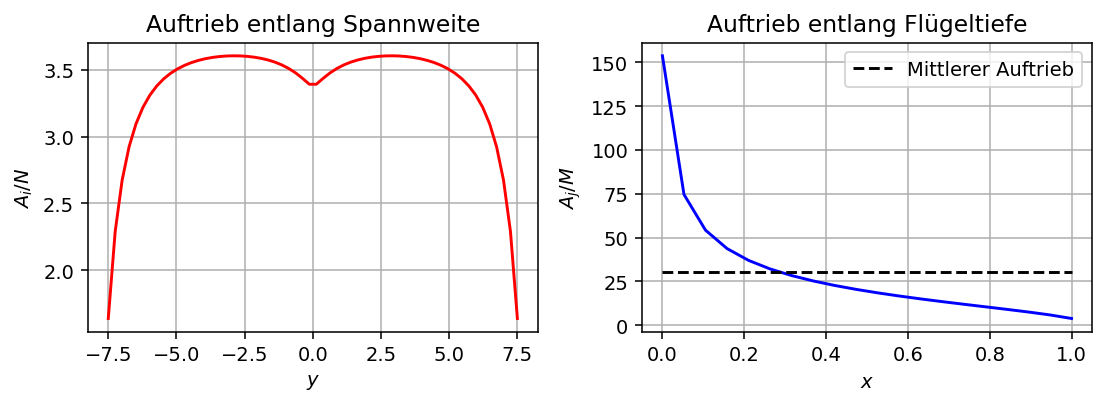

In [473]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

ax1.plot(np.linspace(-s, s, N), A_i/N, '-', color="red", label=r"A")
ax1.set_title("Auftrieb entlang Spannweite")
ax1.set_ylabel(r"$A_i / N$")
ax1.set_xlabel(r"$y$")
ax1.grid(True)


ax2.plot(np.linspace(0, c, M), A_j/M, '-', color="blue")
ax2.plot(np.linspace(0, c, M), np.full((A_j.shape), np.mean(A_j/M)), '--', color="black", label="Mittlerer Auftrieb")
ax2.set_title("Auftrieb entlang Flügeltiefe")
ax2.set_ylabel(r"$A_j / M$")
ax2.set_xlabel(r"$x$")
ax2.grid(True)
ax2.legend()

fig.tight_layout()
plt.show()

## **Aufgabe 1 Mitteneffekt von Pfeilflügeln**
Untersuchen Sie für variierende Pfeilungen $\phi$ die Ausbildungen des Mittenffektes bei Pfeilflügeln. Wie verhält sich der lokale Auftriebsverlauf in Flügeltiefenrichtung? Wie unterscheiden sich die Auftriebsverteilungen von zurückgepfeilten (+$\phi$) und vorgepfeilten (-$\phi$) Flügeln. Begründen Sie Ihre Aussagen.

### Konvergenzstudie


In [474]:
phi = np.radians(15)        # Pfeilungswinkel (in rad)
b = 15                      # Spannweite
s = b/2                     # Halbspannweite
c = 1                       # Flügeltiefe
AR = 12                     # Streckung
U_inf = 30                  # Anströmgeschwindigkeit (in m/s)
alpha = np.radians(5)       # Anstellwinkel (in rad)

In [475]:
results = {}
values = [5, 10, 20, 40]

for N in values:
    for M in values:
        # Zeit speichern
        start_time = time.time()

        # Paneldimensionen berechnen
        Delta_y = b / N
        Delta_x = c / M

        # Berechnen der Koordinaten und Trafo in Vektoren
        X_A, Y_A, X_B, Y_B, X_C, Y_C = compute_coords(s, phi, N, M)
        x_a = matrix_to_vector(X_A)
        y_a = matrix_to_vector(Y_A)
        x_b = matrix_to_vector(X_B)
        y_b = matrix_to_vector(Y_B)
        x_c = matrix_to_vector(X_C)
        y_c = matrix_to_vector(Y_C)

        # Berechnen der Anteile der Zikrulationsmatrix
        a_AB, a_Aoo, a_Boo = compute_coeff_matrices(y_a, y_b, y_c, x_a, x_b, x_c)
        a = a_AB + a_Aoo - a_Boo        
        a_ind_vec = a_Aoo - a_Boo
        Gamma_vec = np.linalg.solve(a, np.full((a.shape[0]), alpha) * (- U_inf))
        Gamma = vector_to_matrix(Gamma_vec, N, M)

        # Berechnen von Auftrieb und Auftriebsanstieg
        Gamma_span = np.sum(Gamma, axis=1) 
        A_ges = rho * U_inf * np.sum(Gamma_span * Delta_y)
        C_A = A_ges / (0.5 * rho * U_inf**2 * b * c)
        C_A_alpha = C_A / alpha

        # Berechnen des indzierten Widerstandes

        w_ind = vector_to_matrix(a_ind_vec @ Gamma_vec, N, M)
        W_ind = - rho * U_inf * np.sum(Gamma * w_ind * Delta_y * Delta_x)
        C_W_ind = 2*W_ind / rho / U_inf**2 / (b*c)

        result_dict = {
            "C_A": C_A.item(),
            "dC_A/dalpha": C_A_alpha.item(),
            "C_W": C_W_ind.item(),
            "Rechenzeit": time.time() -start_time
        }

        results[(N, M)] = result_dict

results

{(5, 5): {'C_A': -0.6635896666331033,
  'dC_A/dalpha': -7.604177445314018,
  'C_W': 0.9076793044615303,
  'Rechenzeit': 0.0058629512786865234},
 (5, 10): {'C_A': -3.1861126212747286,
  'dC_A/dalpha': -36.510161250481126,
  'C_W': 3.7876368900908104,
  'Rechenzeit': 0.05986595153808594},
 (5, 20): {'C_A': -12.45923560792087,
  'dC_A/dalpha': -142.7723232585957,
  'C_W': -176.89607279461788,
  'Rechenzeit': 0.07226419448852539},
 (5, 40): {'C_A': -14.506542703368233,
  'dC_A/dalpha': -166.2327344458599,
  'C_W': -198.66854015094975,
  'Rechenzeit': 0.248948335647583},
 (10, 5): {'C_A': 0.4626097722827631,
  'dC_A/dalpha': 5.301117502662084,
  'C_W': 0.02196505733078422,
  'Rechenzeit': 0.01718616485595703},
 (10, 10): {'C_A': 0.4626136022295416,
  'dC_A/dalpha': 5.301161390619317,
  'C_W': 0.010610445728110759,
  'Rechenzeit': 0.0662541389465332},
 (10, 20): {'C_A': 0.4626145558838088,
  'dC_A/dalpha': 5.301172318692242,
  'C_W': 0.005213524728113957,
  'Rechenzeit': 0.2413790225982666},